### Import and Download Packages

In [11]:
import string 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
import os 
import scipy as sp
import nltk
from sklearn.neighbors import KernelDensity as KDE
import sqlite3
%matplotlib inline
from IPython.display import display, HTML
import networkx as nx
from nltk.corpus import wordnet as wn 
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from scipy.cluster.hierarchy import ward,dendrogram
from gensim import corpora, models,similarities 
from nltk.tag import pos_tag
from nltk.stem.snowball import SnowballStemmer

In [12]:
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/nh4mq/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nh4mq/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/nh4mq/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Configure

In [100]:
db_file='./novels.db'

In [14]:
pd.set_option('display.max_rows',999)

### Functions

In [94]:
def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

def indiviudal_book_analysis(db_file,slug,vocab_weight = 'tf_sum',vocab_weight_quantile = .94,
                             vocab_min_n = 3,kde_kernel = 'gaussian',kde_bandwidth = 2000,kde_samples = 1000):
    with sqlite3.connect(db_file) as db:
            V = pd.read_sql("SELECT * FROM vocab WHERE stop = 0", db, index_col='term_id')
            K = pd.read_sql("SELECT term_id, term_str FROM token WHERE term_id >= 0", db)
    K.rename_axis('offset', inplace=True)
    V1 = V[(V[vocab_weight] > V[vocab_weight].quantile(vocab_weight_quantile)) & (V.n >= vocab_min_n)]
    print(V1.sort_values(vocab_weight, ascending=False).head(5).T)
    TOP_TERMS = V.sort_values(vocab_weight, ascending=False).term_str.head(30).tolist()
    K = K[K.term_id.isin(V1.index)]
    B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()
    B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)
    scale_max = K.index.max() # THIS IS CRUCIAL
    x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
    B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
    B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)
    # B['scaled'] = B.apply(lambda row: np.exp(row.scores) * (scale_max / kde_samples), axis=1)
    PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)
    fig1, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    PLOTS.loc[TOP_TERMS[0]].plot(ax=ax1)
    PLOTS.loc[TOP_TERMS[1]].plot(ax=ax1)
    ax1.title.set_text('{},{} KDE Plot'.format(TOP_TERMS[0],TOP_TERMS[1]))
    fig1.show()
    fig2, ax2 = plt.subplots(1, 1, figsize=(15, 5))
    PLOTS.loc[TOP_TERMS[2]].plot(ax=ax2)
    PLOTS.loc[TOP_TERMS[3]].plot(ax=ax2)
    ax2.title.set_text('{},{} KDE Plot'.format(TOP_TERMS[2],TOP_TERMS[3]))
    fig2.show()
    pairs = pd.DataFrame([(x,y) for x in B.index for y in B.index if y > x] , columns=['x','y'])
    def overlap(row):
        kde1 = PLOTS.loc[row.x]
        kde2 = PLOTS.loc[row.y]
        overlap = np.minimum(kde1, kde2)
        return np.trapz(overlap)
    pairs['overlap'] = pairs.apply(overlap, axis=1)
    def paircorr(row):
        return PLOTS.T[[row.x,row.y]].corr().values[0][1]
    pairs['corr'] = pairs.apply(paircorr, axis=1)
    fig3,ax3=plt.subplots(1,1,figsize=(6,6))
    pairs.overlap.plot.hist(ax=ax3)
    fig3.show()
    pairs2 = pairs.copy().rename(columns={'x':'y', 'y':'x'})
    pairs3 = pd.concat([pairs, pairs2], sort=True)
    DETAIL = '<table>'
    for i, term in enumerate(TOP_TERMS):
        friends = pairs3[pairs3.x == term].sort_values('overlap', ascending=False).head(10)
        DETAIL += "<tr><td colspan=1><b>{}. {}</b></td></tr>".format(i+1, term)
        for row in friends.reset_index(drop=True)[['y', 'overlap']].values:
            bar = round(row[1] * 100) * '|'
            DETAIL += "<tr><td>{}</td><td style='text-align:left;'>{} ({})</td></tr>".format(row[0], bar, row[1])
    DETAIL += "</table>"
    display(HTML(DETAIL))
    CORR = pd.crosstab(pairs3.x, pairs3.y, pairs3.overlap, aggfunc='sum').fillna(1)
    def corr_plot_terms(terms, dtm, title='Foo'):
        plt.figure(figsize = (20,20))
        print(title)
        corr = dtm[terms].corr()
        sns.heatmap(corr, vmax=.3, annot=True, center=0, 
              cmap='RdYlGn',
              square=True, linewidths=.5, 
              cbar_kws={"shrink": .5})
        plt.show()
    try: 
        corr_plot_terms(TOP_TERMS, PLOTS.T, title='TEST')
    except: 
        pass
    G = nx.Graph()
    edges = pairs[['x','y','overlap']].sort_values('overlap', ascending=False).head(1000).apply(lambda x: (x.x, x.y, x.overlap), axis=1).values
    G.add_weighted_edges_from(edges)
    nx.write_gexf(G, "{}.gexf".format(slug))
    with sqlite3.connect(db_file) as db:
        pairs.to_sql('term_pair', db, if_exists='replace', index=True)
    PLOTS.T.to_sql('term_kde', db, if_exists='replace', index=True)
    
def create_chaps(db_file):
    with sqlite3.connect(db_file) as db:
        tokens = pd.read_sql("SELECT * FROM token WHERE term_id >= 0", db)
    paras2 = tokens.groupby(['chap_num','para_num']).token_str.apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'token_str':'para_str'})
    chaps2 = paras2.groupby(['chap_num']).para_str.apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'para_str':'chap_str'})
    return chaps2
    
        
    
    

def analyze_sentiment_vader_lexion(chapter, 
                                    threshold=0.1,
                                    verbose=False):
        # analyze the sentiment for chapter
        analyzer = SentimentIntensityAnalyzer()
        scores = analyzer.polarity_scores(chapter)
        # get aggregate scores and final sentiment
        agg_score = scores['compound']
        final_sentiment = 'positive' if agg_score >= threshold\
                                   else 'negative'
        if verbose:
            # display detailed sentiment statistics
            positive = str(round(scores['pos'], 2)*100)+'%'
            final = round(agg_score, 2)
            negative = str(round(scores['neg'], 2)*100)+'%'
            neutral = str(round(scores['neu'], 2)*100)+'%'
        return final_sentiment, final,positive,negative,neutral     

    
def genearte_chap_sentiment(chaps):
    final_sens=[]
    finals=[]
    pos=[]
    neg=[]
    neu=[]
    chap_nums=[]
    for chapter,chap_num in zip(chaps["chap_str"],chaps.index.tolist()):
        final_sentiment, final,positive,negative,neutral=analyze_sentiment_vader_lexion(chapter,threshold=0.4,verbose=True)
        final_sens.append(final_sentiment)
        finals.append(final)
        pos.append(positive)
        neg.append(negative)
        neu.append(neutral)
        chap_nums.append(chap_num)
    sentiment_frame = pd.DataFrame({'Predicted Sentiment':final_sens, 'Polarity Score':finals, 'Positive':pos,
                                        'Negative':neg, 'Neutral':neu,'chap_num':chap_nums})
    return sentiment_frame


###############################Topic Modeling Functions
def tokenize_and_stem(text):
    stemmer = SnowballStemmer("english")
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()


def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns
    
def lda_with_gensim(chaps):
    preprocess = [strip_proppers(chap) for chap in chaps]
    tokenized_text = [tokenize_and_stem(text) for text in preprocess]
    stopwords = nltk.corpus.stopwords.words('english')
    texts = [[word for word in text if word not in stopwords] for text in tokenized_text]
    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=1, no_above=0.8)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda = models.LdaModel(corpus, num_topics=5, 
                            id2word=dictionary, 
                            update_every=5, 
                            chunksize=20,
                            passes=10)
    topics_matrix = lda.show_topics(formatted=False, num_words=20)
    for j in range(5):
        i=topics_matrix[j][1]
        plt.barh(range(len(i)),[val[1] for val in i],align='center')
        plt.yticks(range(len(i)),[val[0] for val in i])
        plt.title("Topic {}".format(topics_matrix[j][0]))
        plt.show()

### Investigate K-Means Outliers

##### The Outlet
##### The Last of Mohicans
##### The Log of A Cowboy
###### There are three outliers in the K-means result. Let us investigate one novel from the common group and compare with these three novels. 
##### Common Group (cluster 4 :The Mystery of the Cloomber )

### Find the Book Num of the four novels 

In [101]:
with sqlite3.connect(db_file) as db:
        doc = pd.read_sql("SELECT * FROM doc", db)
        

In [102]:
for i in range(len(doc["title"])):
    if doc["title"][i] in ["The Log of a Cowboy","The Last of the Mohicans","The Outlet","The Mystery of the Cloomber"]:
        print (i)

1
8
39
51


### Analyze Book_Num =1 Book  

In [24]:
doc["title"][1]

'The Log of a Cowboy'

term_id            3646         1456         2943         46           990 
term_str            log       cowboy         herd           's       cattle
n                    12            5          616          472          453
p           0.000119361  4.97339e-05   0.00612722   0.00469488   0.00450589
port_stem           log       cowboy         herd           's        cattl
stop                  0            0            0            0            0
df                    6            4           24           24           24
tf_sum         0.503022      0.50045     0.315332     0.260221     0.229358
tf_mean       0.0201209     0.020018    0.0126133    0.0104088    0.0091743
tf_max         0.498214     0.498214    0.0308897    0.0228011    0.0273372
tfidf_sum       1.03567      1.32312     0.018571    0.0153254    0.0135077
tfidf_mean    0.0414267    0.0529247  0.000742842  0.000613015  0.000540309
tfidf_max       1.02577      1.31721   0.00181921   0.00134284   0.00160999
tfth_sum    

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


TEST


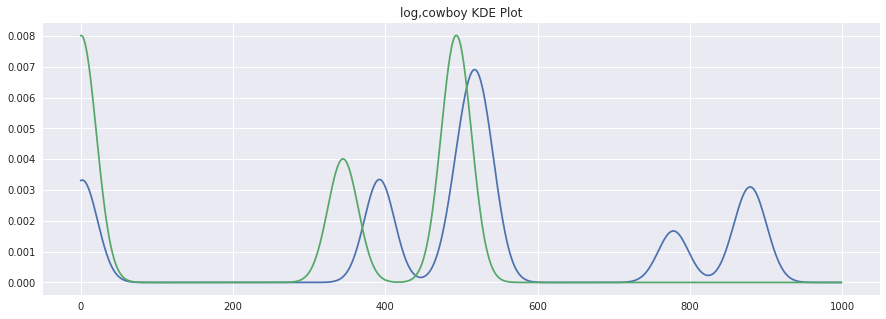

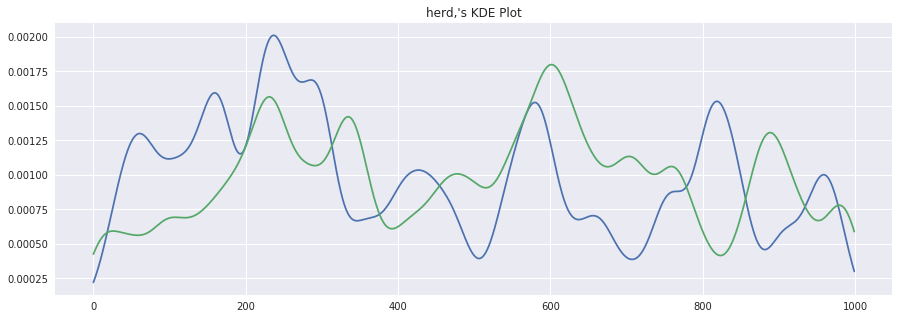

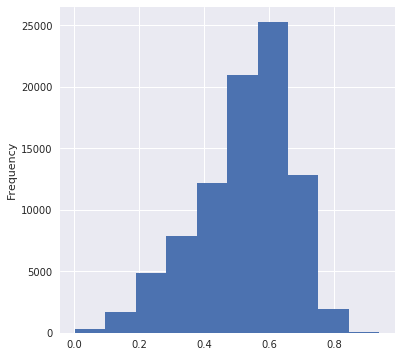

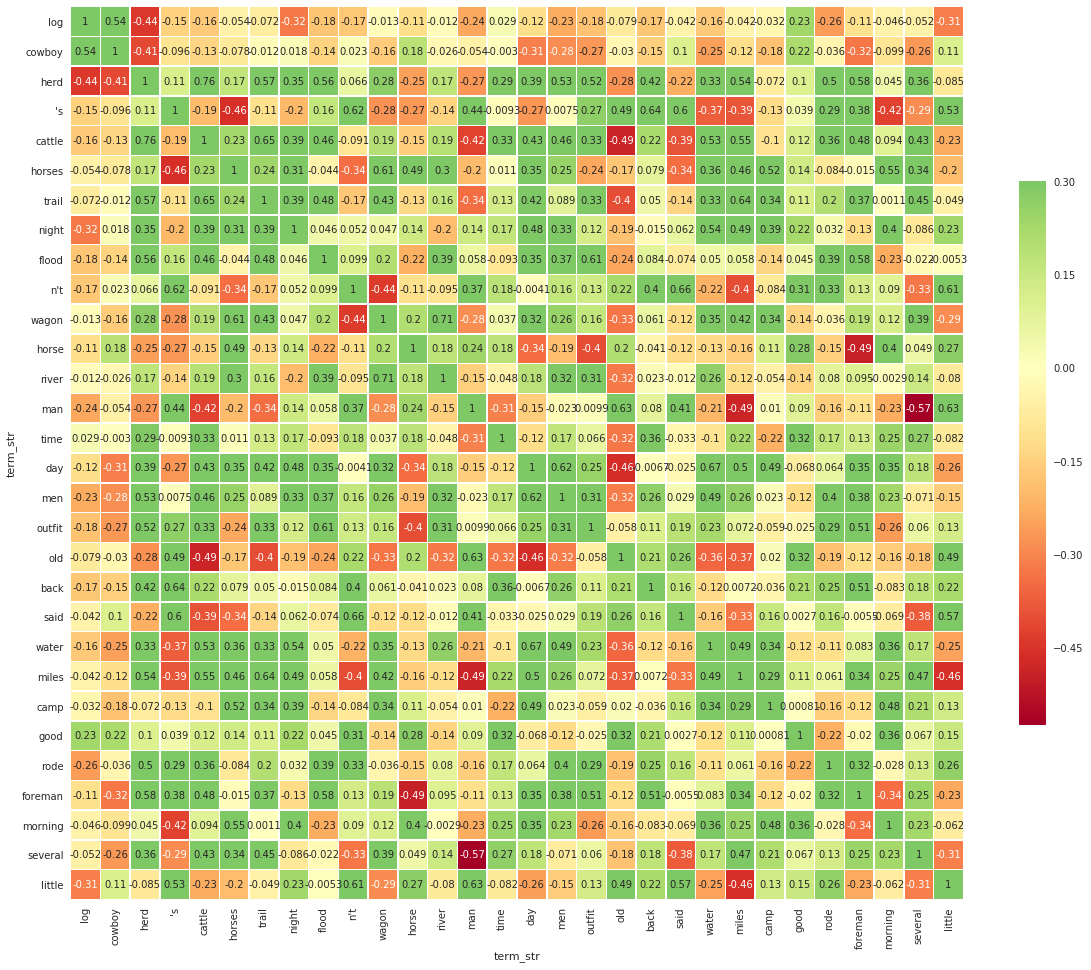

In [78]:
indiviudal_book_analysis(r'./databases/1903 the log of a cowboy.db',slug="1903_the_log_of_a_cowboy")

### WordNet

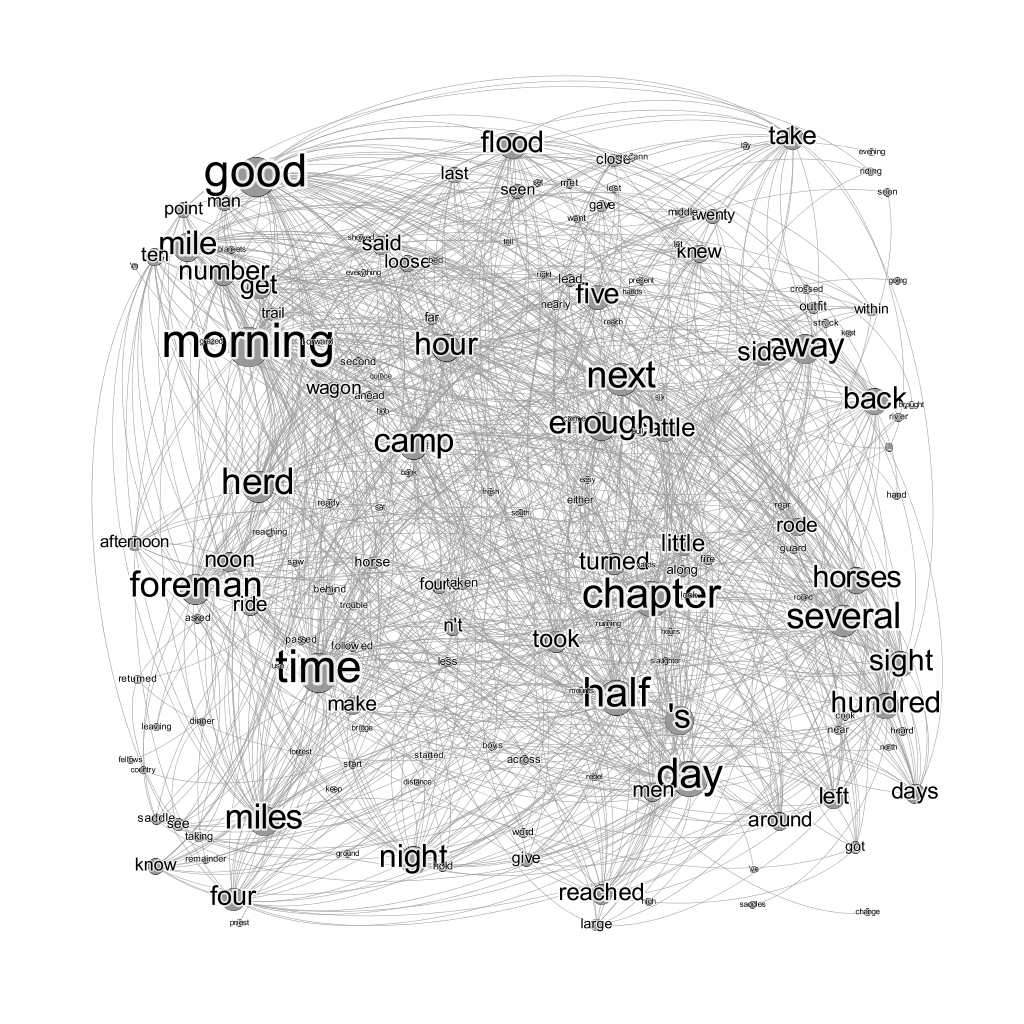

In [1]:
#gephi graph of this book 
from IPython.display import display
from PIL import Image

path="./WorldNet1903.png"
display(Image.open(path))

### Sentiment Analysis By Chapter

In [92]:
chaps=create_chaps(db_file=r'./databases/1903 the log of a cowboy.db')
senti_result=genearte_chap_sentiment(chaps)
senti_result["Positive"]=senti_result["Positive"].apply(lambda x: int(x.split('.')[0]))
senti_result["Negative"]=senti_result["Negative"].apply(lambda x: int(x.split('.')[0]))
senti_result["Neutral"]=senti_result["Neutral"].apply(lambda x: int(x.split('.')[0]))

Text(0.5,1,'Sentiment Changes by Chapter')

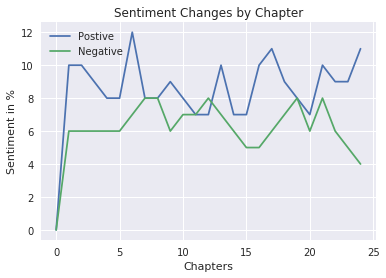

In [93]:
fig,ax=plt.subplots()
senti_result["Positive"].plot(kind="line",ax=ax)
senti_result["Negative"].plot(kind="line",ax=ax)
ax.legend(["Postive","Negative","Neutral"])
ax.set_xlabel("Chapters")
ax.set_ylabel("Sentiment in %")
ax.set_title("Sentiment Changes by Chapter")

### LDA Topic Modeling

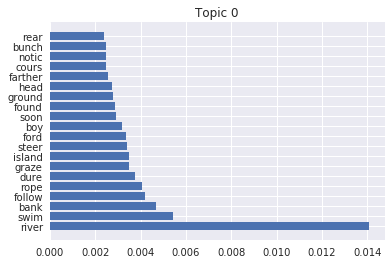

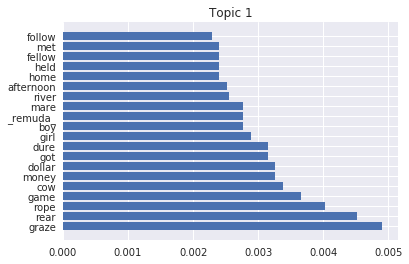

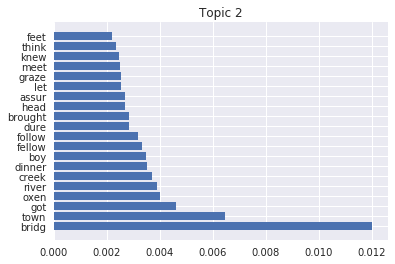

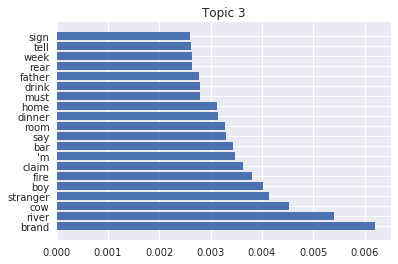

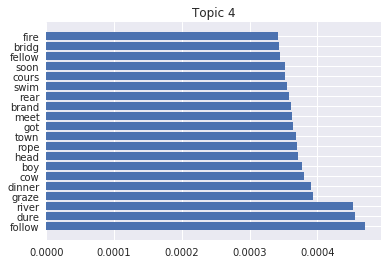

In [95]:
lda_with_gensim(chaps["chap_str"])

## Analyze Book_Num = 8 Book

In [103]:
doc["title"][8]

'The Last of the Mohicans'

term_id            4944         5507        7436         4157         7330
term_str           last     mohicans       scout      heyward         said
n                    56           56         369          343          342
p           0.000378906  0.000378906  0.00249672    0.0023208   0.00231403
port_stem          last      mohican       scout      heyward         said
stop                  0            0           0            0            0
df                   27           17          28           30           33
tf_sum         0.194237     0.193789    0.182563     0.172729     0.172467
tf_mean      0.00571285   0.00569969   0.0053695   0.00508026   0.00507255
tf_max         0.166398     0.166398   0.0143061     0.013793   0.00965511
tfidf_sum     0.0645984     0.193789   0.0511373    0.0311901   0.00742792
tfidf_mean   0.00189995   0.00569969  0.00150404  0.000917355  0.000218468
tfidf_max       0.05534     0.166398  0.00400725   0.00249064  0.000415833
tfth_sum       0.135136  

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


TEST


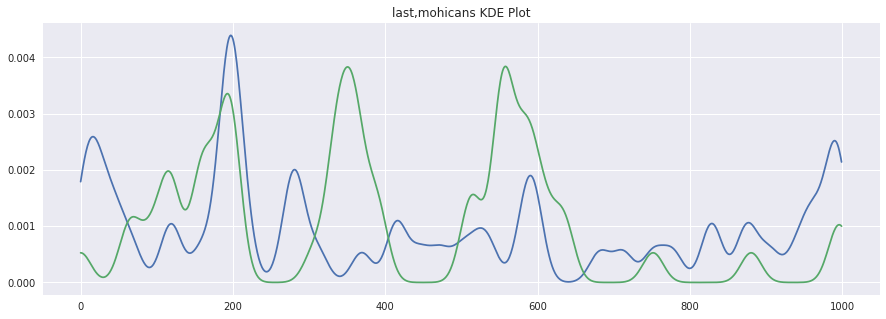

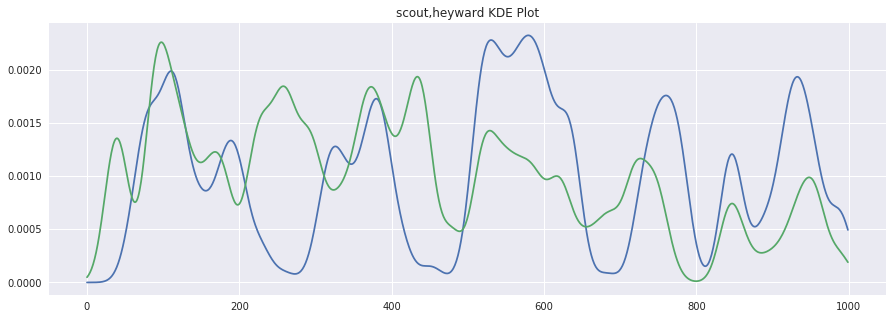

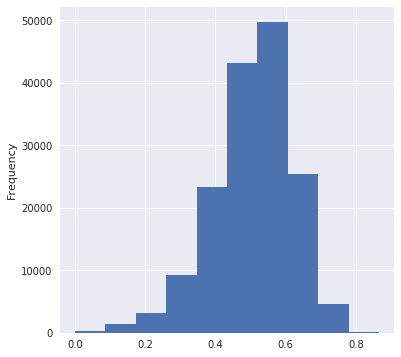

<Figure size 1440x1440 with 0 Axes>

In [104]:
indiviudal_book_analysis(r'./databases/1826_Cooper_JameFenimore_TheLastoftheMohicans_Novel.db',slug="1826_Last_Mohicans")

### Wordnet

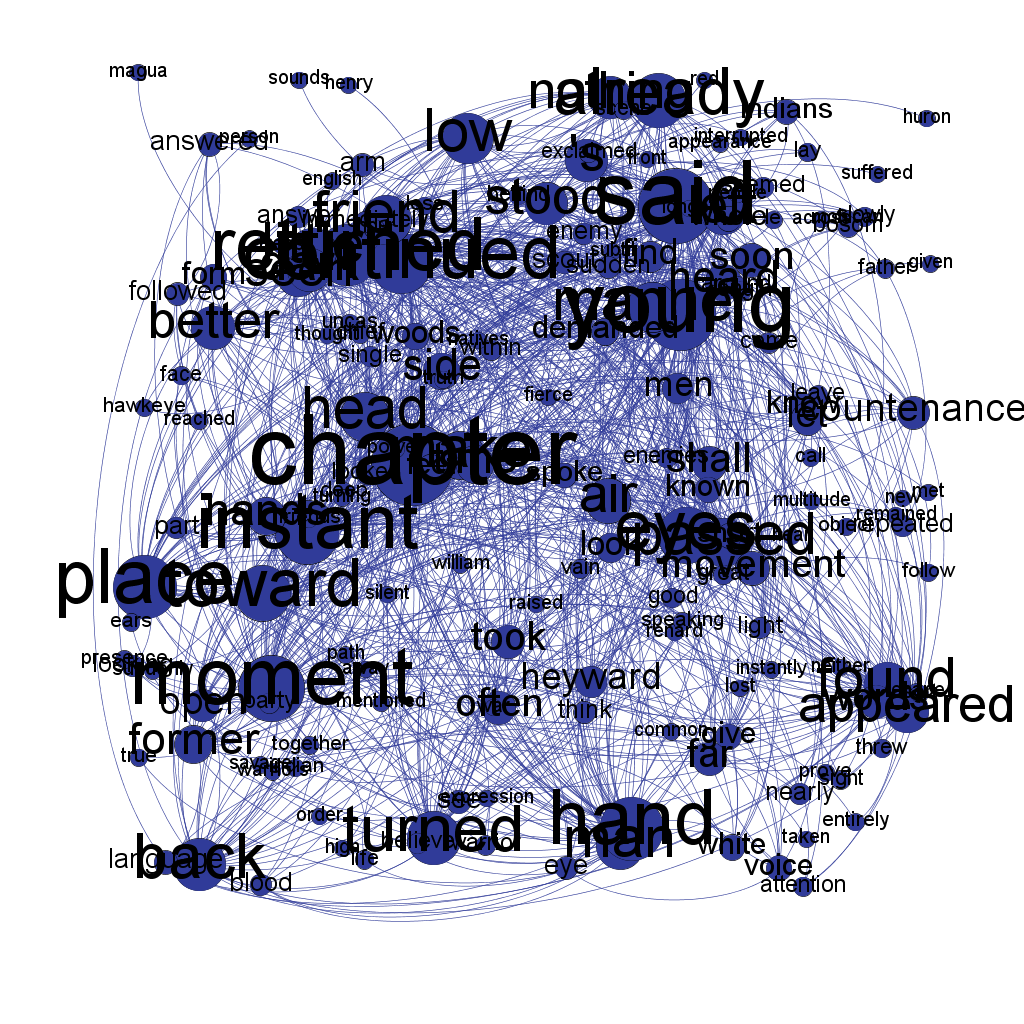

In [2]:
#gephi graph of this book 
from IPython.display import display
from PIL import Image

path="./WorldNet1826.png"
display(Image.open(path))

### Sentiment Analysis By Chapter

In [105]:
chaps=create_chaps(db_file=r'./databases/1826_Cooper_JameFenimore_TheLastoftheMohicans_Novel.db')
senti_result=genearte_chap_sentiment(chaps)
senti_result["Positive"]=senti_result["Positive"].apply(lambda x: int(x.split('.')[0]))
senti_result["Negative"]=senti_result["Negative"].apply(lambda x: int(x.split('.')[0]))
senti_result["Neutral"]=senti_result["Neutral"].apply(lambda x: int(x.split('.')[0]))

Text(0.5,1,'Sentiment Changes by Chapter')

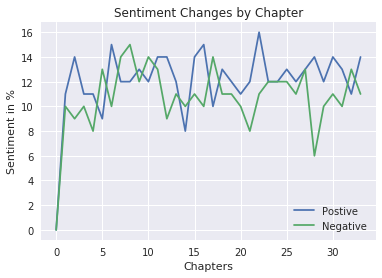

In [106]:
fig,ax=plt.subplots()
senti_result["Positive"].plot(kind="line",ax=ax)
senti_result["Negative"].plot(kind="line",ax=ax)
ax.legend(["Postive","Negative","Neutral"])
ax.set_xlabel("Chapters")
ax.set_ylabel("Sentiment in %")
ax.set_title("Sentiment Changes by Chapter")

### LDA Topic Modeling

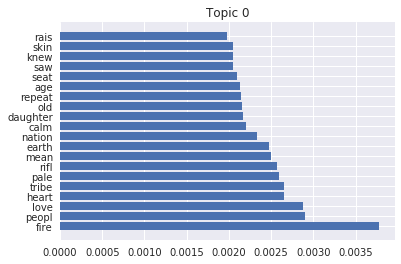

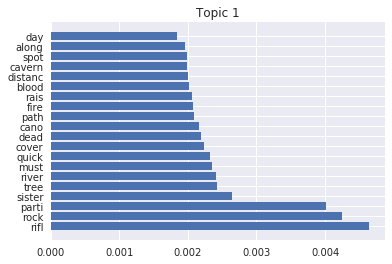

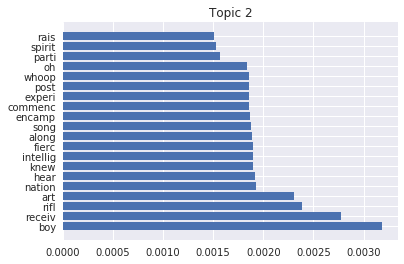

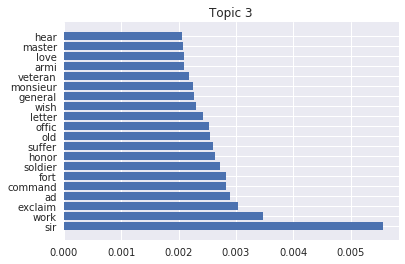

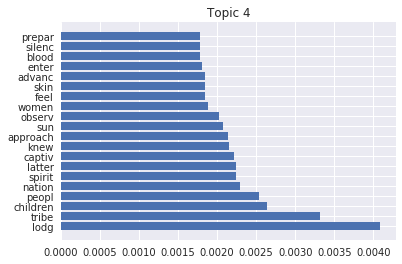

In [107]:
lda_with_gensim(chaps["chap_str"])

## Analyze Book_Num = 39 Book

In [109]:
doc["title"][39]

'The Mystery of the Cloomber'

term_id           22          4748        3392        2316         1998
term_str            's        said         man     general       father
n                  218         180         121         115           89
p           0.00440004  0.00363306  0.00244222  0.00232112   0.00179635
port_stem           's        said         man       gener       father
stop                 0           0           0           0            0
df                  16          14          16          13           14
tf_sum        0.165228    0.149243   0.0916432   0.0883641    0.0742716
tf_mean      0.0103268  0.00932768   0.0057277  0.00552275   0.00464198
tf_max       0.0179163   0.0248173   0.0087463    0.015549    0.0102189
tfidf_sum            0   0.0287509           0   0.0264704    0.0143081
tfidf_mean           0  0.00179693           0   0.0016544  0.000894254
tfidf_max            0  0.00478093           0  0.00465786   0.00196862
tfth_sum       0.17727     0.13931    0.061721   0.0536766    0.

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


TEST


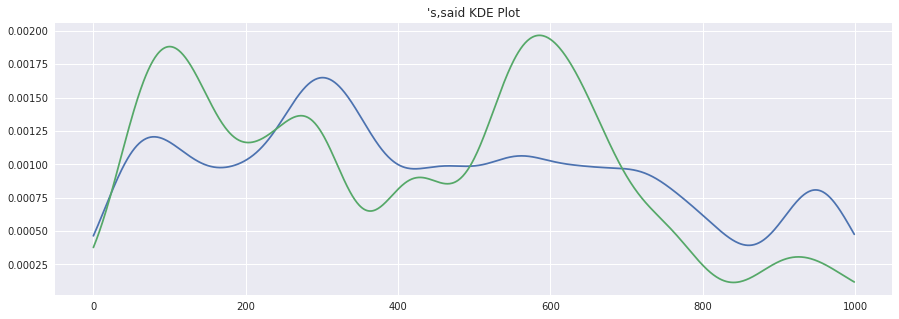

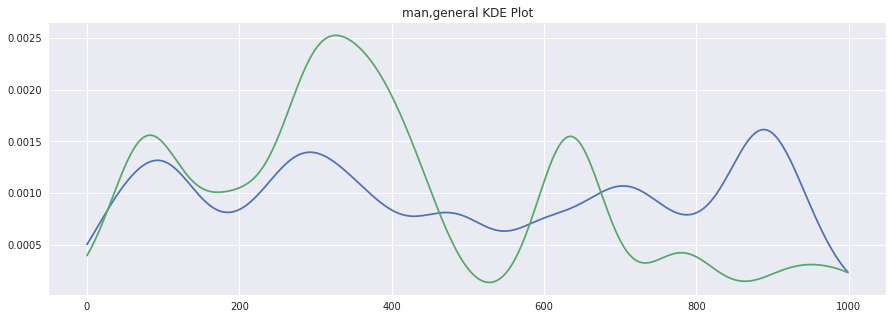

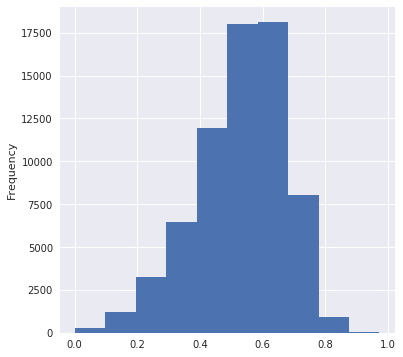

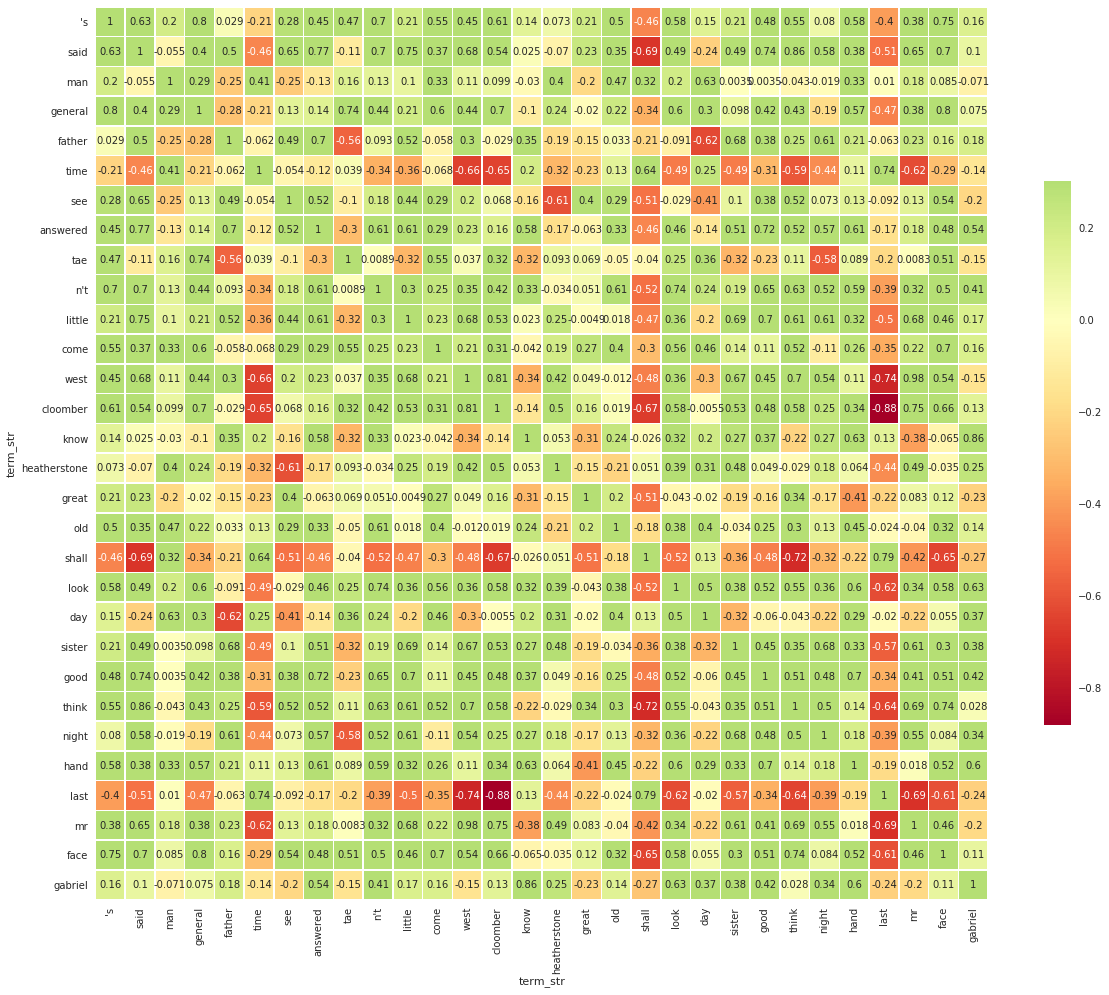

In [110]:
indiviudal_book_analysis(r'./databases/1889_Doyle_ArthurConan_TheMysteryoftheCloomber_Novel.db',slug="1889_Mystery_Cloomber")

### WordNet

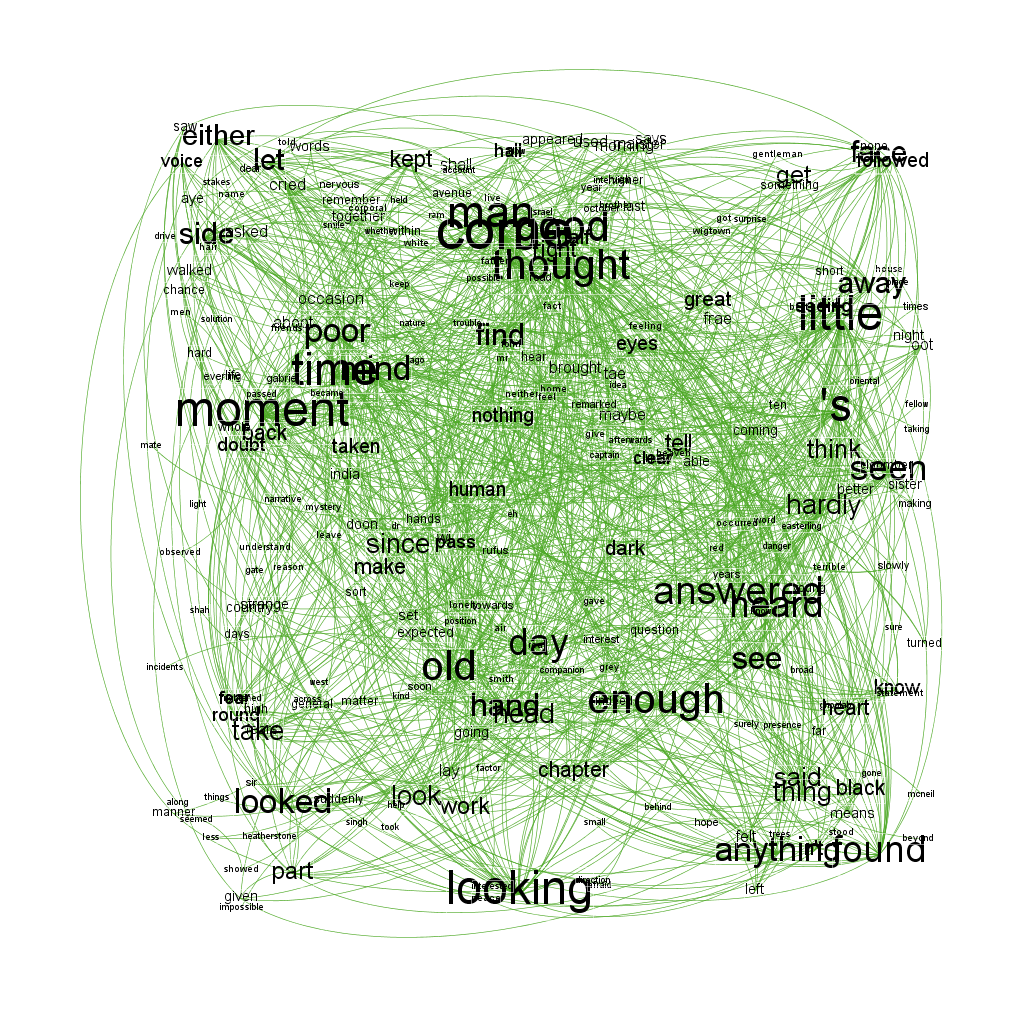

In [3]:
#gephi graph of this book 
from IPython.display import display
from PIL import Image

path="./WorldNet1889.png"
display(Image.open(path))

### Sentiment Aanalysis by Chapter

In [111]:
chaps=create_chaps(db_file=r'./databases/1889_Doyle_ArthurConan_TheMysteryoftheCloomber_Novel.db')
senti_result=genearte_chap_sentiment(chaps)
senti_result["Positive"]=senti_result["Positive"].apply(lambda x: int(x.split('.')[0]))
senti_result["Negative"]=senti_result["Negative"].apply(lambda x: int(x.split('.')[0]))
senti_result["Neutral"]=senti_result["Neutral"].apply(lambda x: int(x.split('.')[0]))

Text(0.5,1,'Sentiment Changes by Chapter')

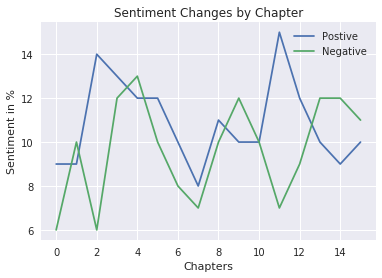

In [112]:
fig,ax=plt.subplots()
senti_result["Positive"].plot(kind="line",ax=ax)
senti_result["Negative"].plot(kind="line",ax=ax)
ax.legend(["Postive","Negative","Neutral"])
ax.set_xlabel("Chapters")
ax.set_ylabel("Sentiment in %")
ax.set_title("Sentiment Changes by Chapter")

### LDA Modeling

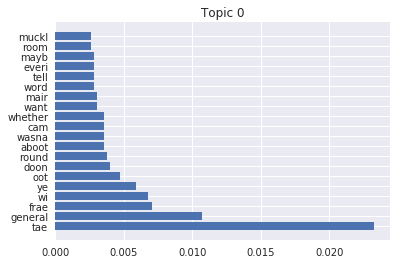

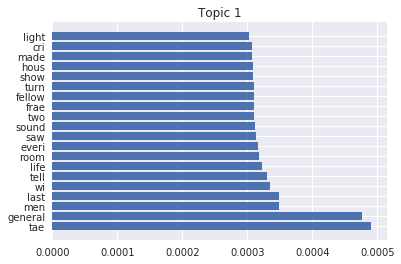

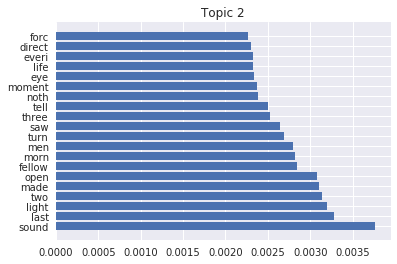

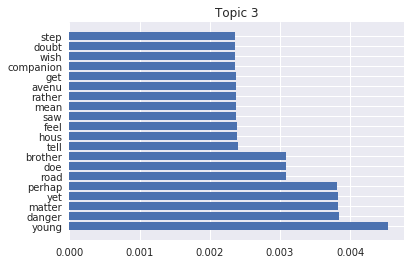

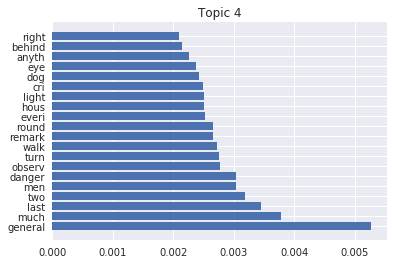

In [113]:
lda_with_gensim(chaps["chap_str"])

## Analyze Book_Num=51 Book

In [114]:
doc["title"][51]

'The Outlet'

term_id           30          1036         3047         3881        5416
term_str            's      cattle         herd          man       river
n                  565         557          332          254         216
p           0.00588578  0.00580245   0.00345855     0.002646  0.00225014
port_stem           's       cattl         herd          man       river
stop                 0           0            0            0           0
df                  25          25           24           24          25
tf_sum        0.330708    0.326252      0.18544     0.143463    0.124279
tf_mean      0.0132283   0.0130501   0.00741762   0.00573854  0.00497116
tf_max       0.0255402   0.0223376    0.0166233    0.0110821   0.0196275
tfidf_sum            0           0    0.0109213   0.00844909           0
tfidf_mean           0           0  0.000436851  0.000337964           0
tfidf_max            0           0  0.000979008  0.000652665           0
tfth_sum      0.669129    0.653908     0.231032    

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


TEST


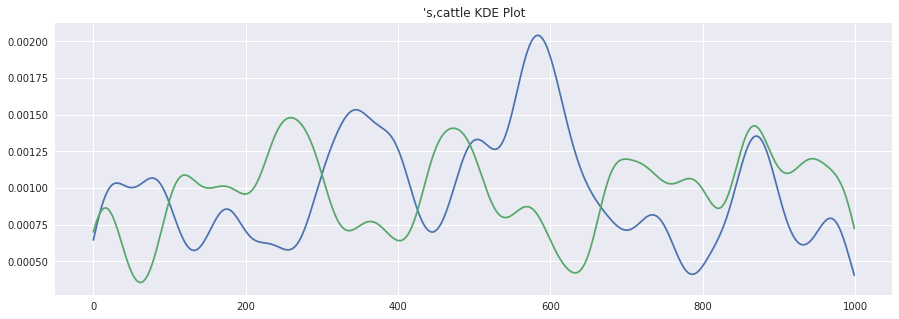

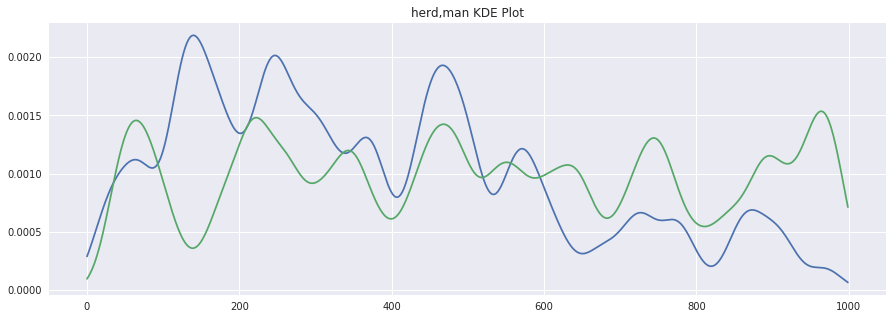

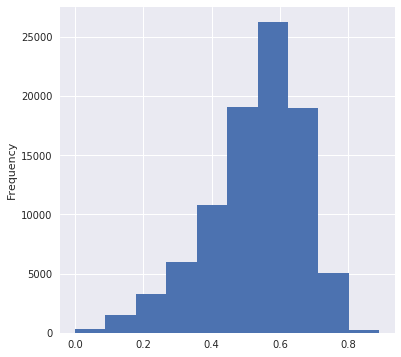

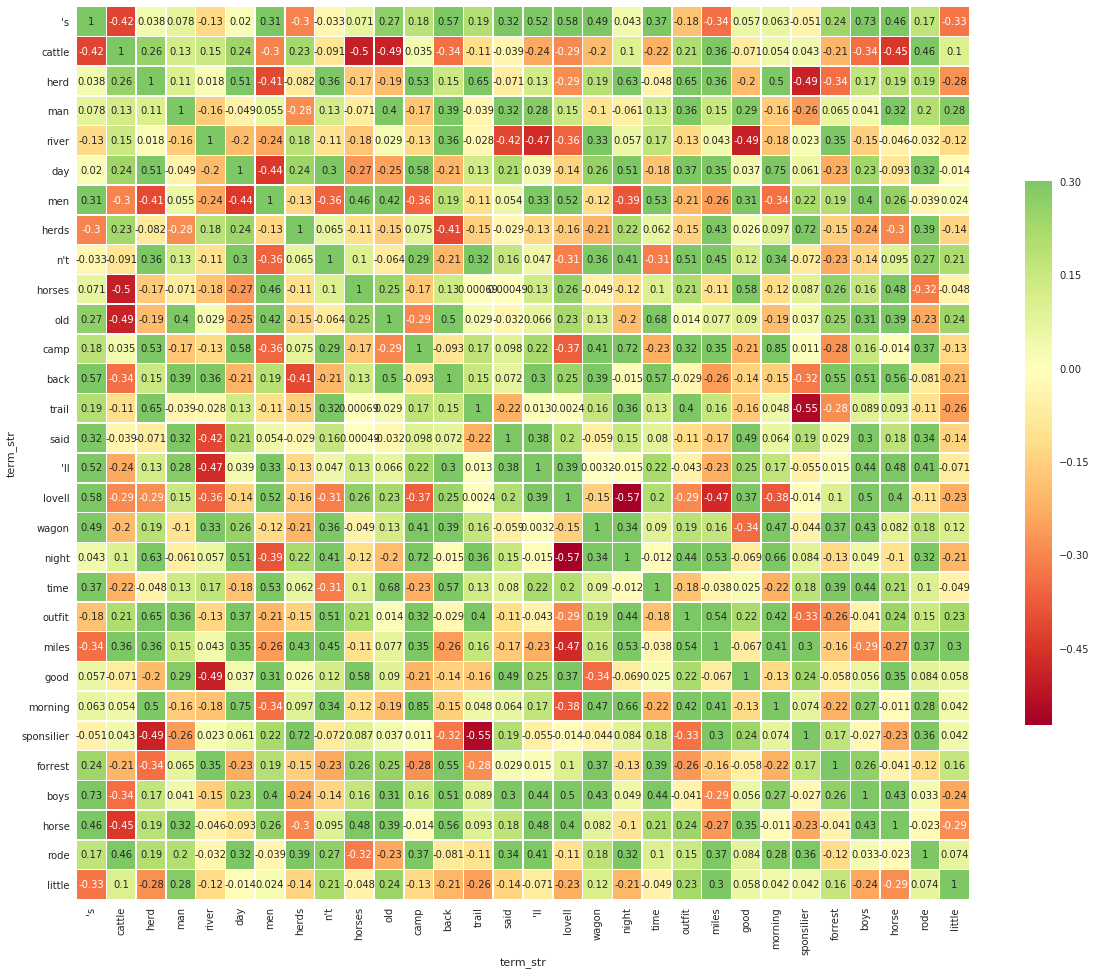

In [115]:
indiviudal_book_analysis(r'./databases/1905 the outlet.db',slug="1905_the_outlet")

### WordNet

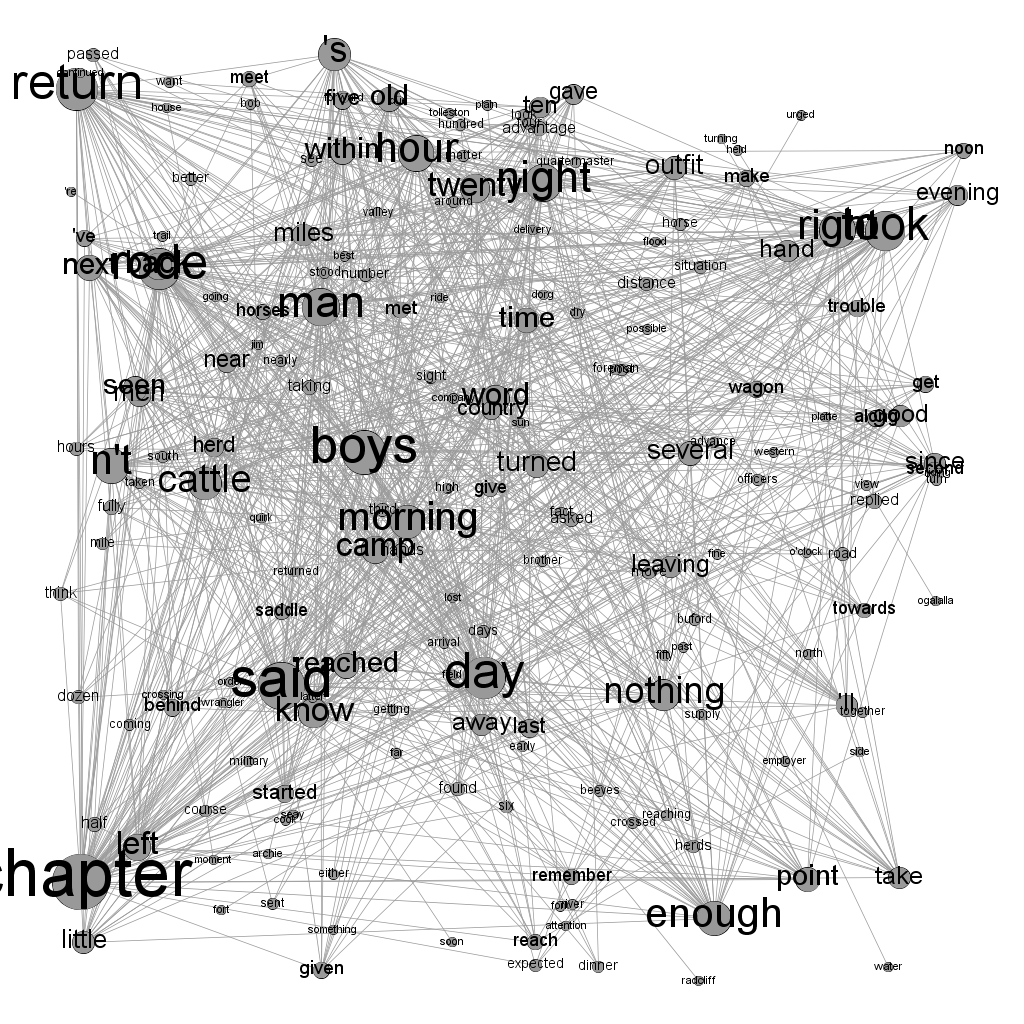

In [4]:
#gephi graph of this book 
from IPython.display import display
from PIL import Image

path="./WorldNet1905.png"
display(Image.open(path))

### Sentiment Analysis by Chatper

In [116]:
chaps=create_chaps(db_file=r'./databases/1905 the outlet.db')
senti_result=genearte_chap_sentiment(chaps)
senti_result["Positive"]=senti_result["Positive"].apply(lambda x: int(x.split('.')[0]))
senti_result["Negative"]=senti_result["Negative"].apply(lambda x: int(x.split('.')[0]))
senti_result["Neutral"]=senti_result["Neutral"].apply(lambda x: int(x.split('.')[0]))

Text(0.5,1,'Sentiment Changes by Chapter')

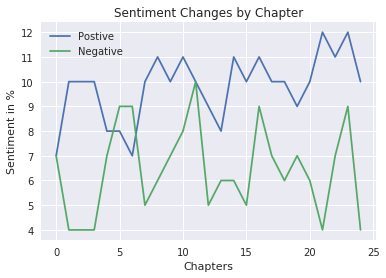

In [117]:
fig,ax=plt.subplots()
senti_result["Positive"].plot(kind="line",ax=ax)
senti_result["Negative"].plot(kind="line",ax=ax)
ax.legend(["Postive","Negative","Neutral"])
ax.set_xlabel("Chapters")
ax.set_ylabel("Sentiment in %")
ax.set_title("Sentiment Changes by Chapter")

### LDA  Topic Modeling

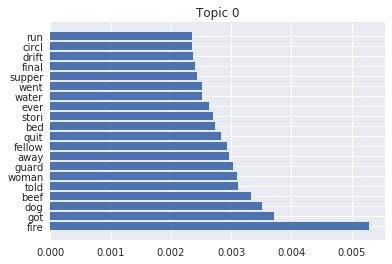

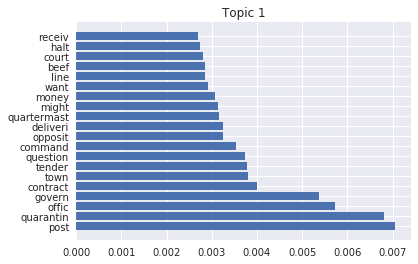

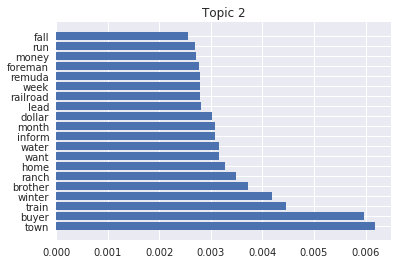

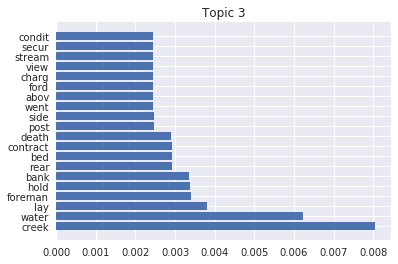

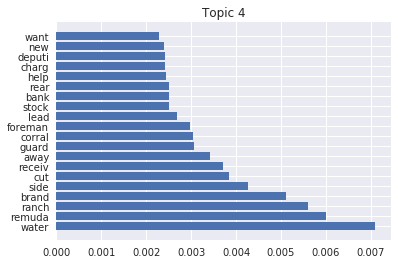

In [118]:
lda_with_gensim(chaps["chap_str"])